# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.
# Imports

In [65]:
# data wrangling
import numpy as np
import pandas as pd
import os.path

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

[example notebook: link](https://github.com/gakhov/pycon-ua-2018/blob/master/stochastic-models.ipynb)

# Parameters

In [90]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [5]:
all_data_path = r'../../data/snow_data_clean.pkl'

In [6]:
long_series_df = pd.read_pickle(all_data_path)
month_ts_df = (long_series_df
               .

## Split Data
I will use supersetting crossvalidation since this is a time series problem.

In [47]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for statsmodels ARIMA models """
    def __init__(self, model_class, endog, order, exog=None, seasonal_order=None):
        self.model_class = model_class
        self.endog = endog
        self.exog=exog
        self.order=order
        self.seasonal_order=seasonal_order
    def fit(self):
        self.model_ = self.model_class(endog=self.endog, exog=self.exog, 
                                       order=self.order, 
                                       seasonal_order=self.seasonal_order)
        self.results_ = self.model_.fit()
        return self.results_
    def predict(self, X):
        return self.results_.predict(X)
    def summary(self):
        return self.results_.summary()
    def score(self):
        self.mse, self.mae = self.results_.mse, self.results_.mae
        self.bic, self.aic = self.results_.bic, self.results_.aic

In [107]:
def time_crossval(model, X, y):
    time_split = TimeSeriesSplit(8)
    cv_results = cross_validate(model, X, y, cv=time_split, 
                            scoring=['neg_root_mean_squared_error', 'r2',
                                     'neg_mean_absolute_error'], n_jobs=-1) 
    return cv_results

In [ ]:
def IC_chooser(model, X, y, param_space):
    """Use AIC/BIC to choose best model from grid of (pdq)(PDQ)S models"""
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for 

In [70]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [9]:
def AC_plotter(df, lags):
    ac_plot = smg.tsaplots.plot_acf(x=df.base,
                                    ax=None, lags=lags, alpha=0.05, 
                                    use_vlines=True, unbiased=False,
                                    missing='conservative',
                                    title=f'Autocorrelation: lag of {lags}', 
                                    zero=True,
                                   )
    ac_plot;

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.
## ARIMA and extensions

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

In [8]:
co_base_ts = (long_series_df
              .query('region=="Colorado"')
              [['base', 'pseudo_ts']]
              .sort_values(by='pseudo_ts')
             )

TimeSeriesSplit(max_train_size=None, n_splits=5)

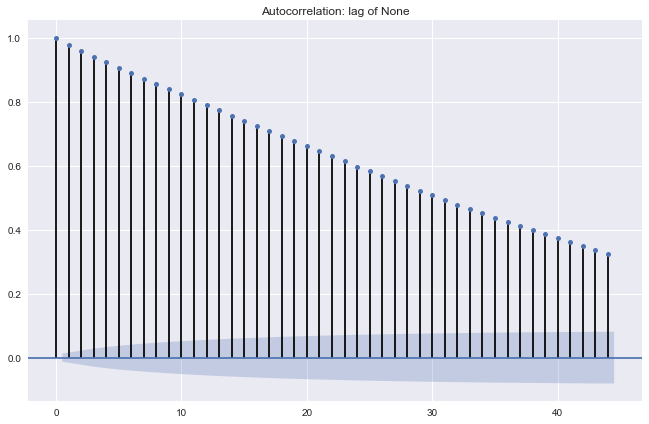

In [29]:
AC_plotter(co_base_ts, None)

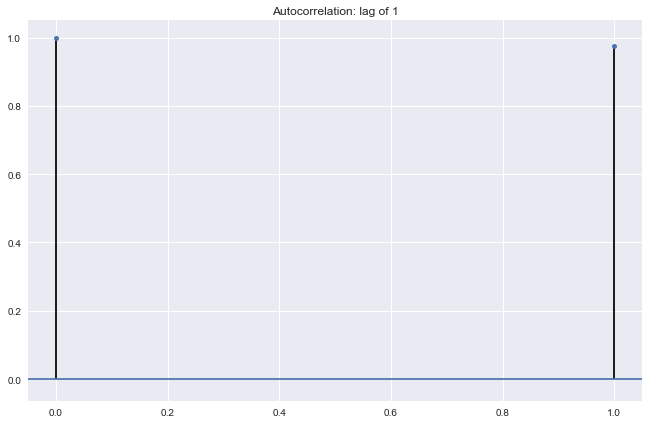

In [30]:
AC_plotter(co_base_ts, 1)

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.

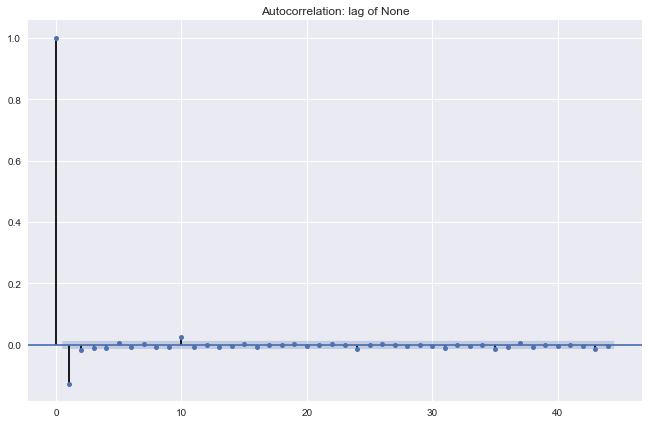

In [31]:
co_base_ts_l1 = co_base_ts.diff(1)
AC_plotter(co_base_ts_l1, None)

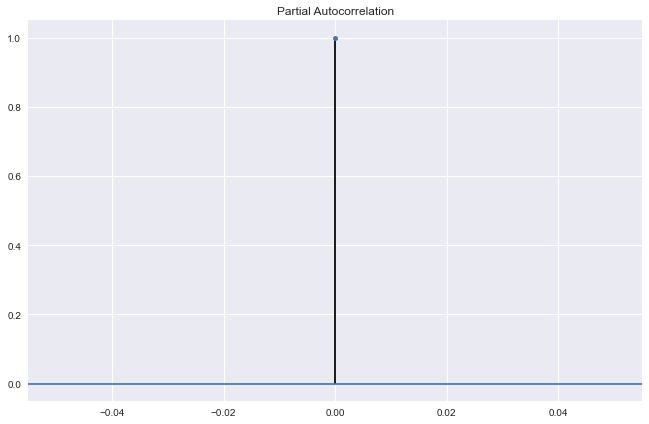

In [32]:
pac_plot = smg.tsaplots.plot_pacf(x=co_base_ts_l1.base, ax=None, lags=1,
                       alpha=0.05, method='ywunbiased', use_vlines=True, 
                       title='Partial Autocorrelation', zero=True, 
                       vlines_kwargs=None,)
pac_plot;

I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [33]:
co_base_ts_valuearr = co_base_ts.values[:,0].astype(np.single)

In [109]:
 # (p, d, q) | (AR, diff, MA) ; need to slice values to get rid of ts data
arima_model = SMWrapper(model_class=smt.arima.model.ARIMA, 
                        endog=co_base_ts_valuearr, order=(0, 1, 1))


arima_model_fit = arima_model.fit()
time_crossval(arima_model, long_series_df.base, long_series_df.base.shift(1).fillna(0))

{'fit_time': array([0.01699901, 0.02400208, 0.01799464, 0.03000021, 0.01999497,
        0.02099776, 0.02400422, 0.02699232]),
 'score_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'test_neg_root_mean_squared_error': array([nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_r2': array([nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan, nan, nan, nan])}

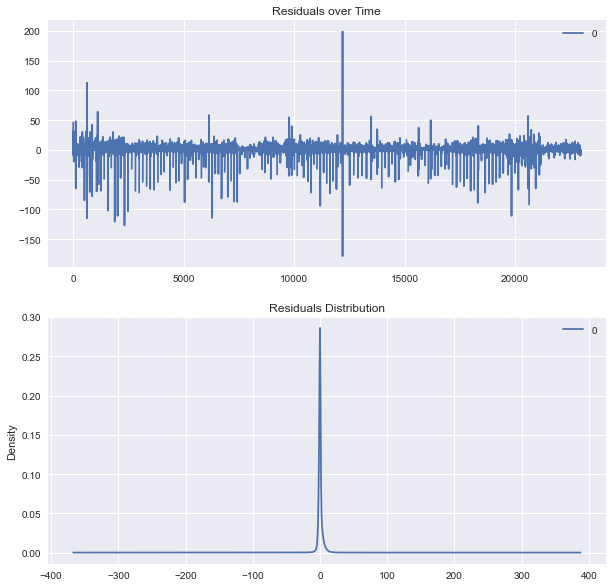

                  0
count  22858.000000
mean       0.004347
std        5.883237
min     -178.589386
25%       -0.998913
50%       -0.000015
75%        0.326271
max      198.892361


In [64]:
def resid_plotter(residuals=None, y=None):
    """plot residual errors"""
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    residuals.plot(title="Residuals over Time", ax=ax1)
    residuals.plot(kind='kde', title="Residuals Distribution", ax=ax2)
    plt.show()
    print(residuals.describe())
arima_resids = pd.DataFrame(arima_model_fit.resid)
resid_plotter(arima_resids)

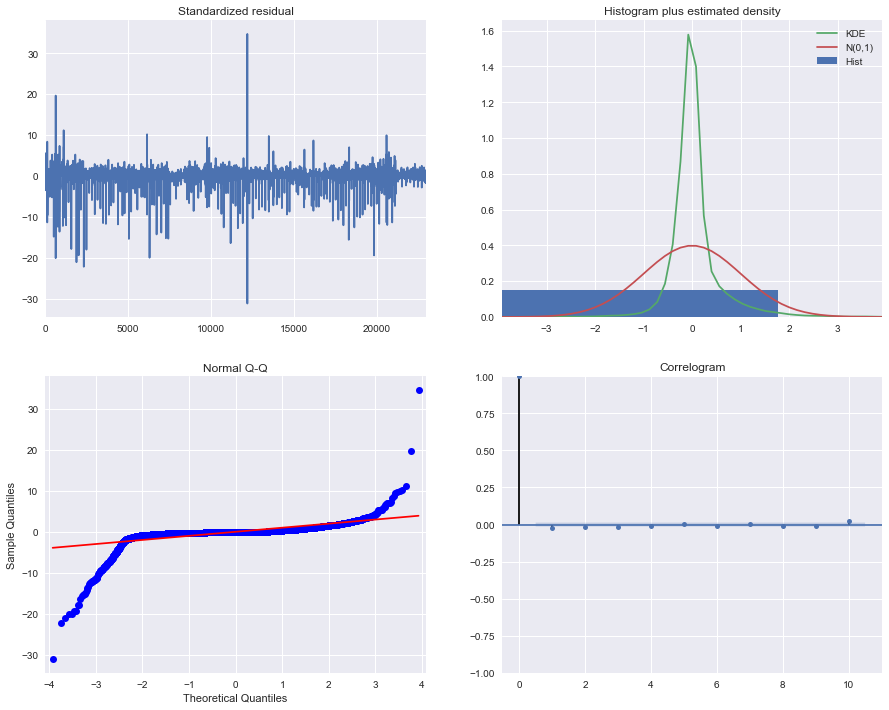

In [91]:
_ = arima_model_fit.plot_diagnostics(figsize=(15, 12))

there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

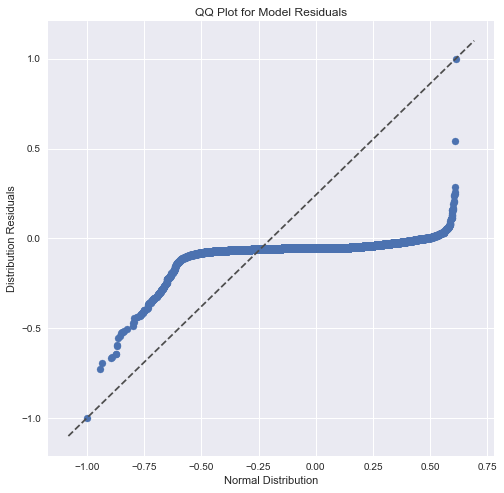

In [51]:
def resid_qqer(residuals):
    size = residuals.shape[0]
    normal = np.random.normal(0, .1, size)
    
    #scale data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    residuals = scaler.fit_transform(residuals.sort_values(by=0))
    normal.sort()
    normal = normal.reshape(-1, 1)
    normal = scaler.fit_transform(normal)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.scatter(x=normal, y=residuals)
    #plt.plot(normal, residuals, "o")
    plt.xlabel('Normal Distribution')
    plt.ylabel('Distribution Residuals')
    plt.title('QQ Plot for Model Residuals')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
    #plt.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()
resid_qqer(arima_resids)

In [53]:
def y_and_yhat_plotter(model=None, endog=None, query_filter=None, date_between=None):
    """endog should be df with time series data and pseudo_ts"""
    df = endog.copy()
    df.columns = ['y', 'pseudo_ts']
    yhat = model.fit().predict()
    df['yhat'] = yhat
    if query_filter:
        df = df.query(query_filter)
    if date_between:
        df = df.loc[df.pseudo_ts.between(*date_between)]
    df = df.melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(data=df, x='pseudo_ts', y='value', hue='variable')
    plt.show();

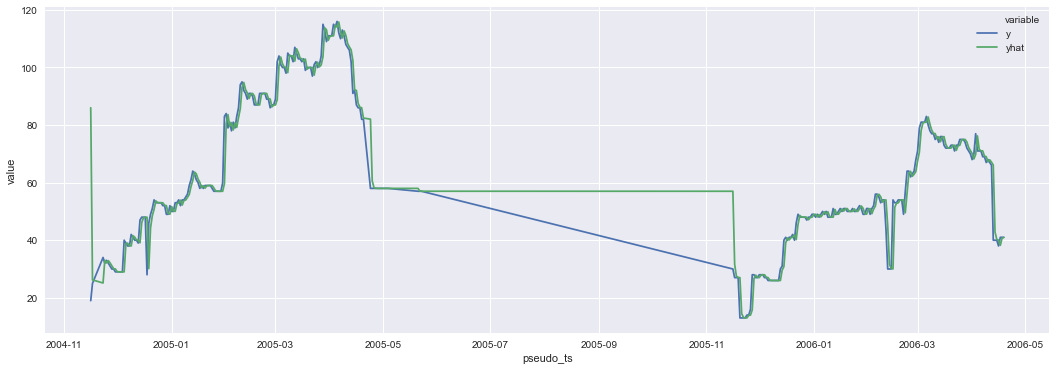

In [54]:
start_d, end_d = '2004-08-01', '2006-07-30'
y_and_yhat_plotter(arima_model, co_base_ts, 
                   query_filter='pseudo_ts>@start_d & pseudo_ts<@end_d')

this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [21]:
sarima_model = smt.arima.model.ARIMA(endog=co_base_ts_valuearr, order=(0, 1, 1),
                                    seasonal_order=(0, 1, 0, 365))
sarima_model_fit = sarima_model.fit()

MemoryError: Unable to allocate 23.2 GiB for an array with shape (368, 368, 22994) and data type float64

ARIMAX using snowfall data with powder -> packed powder and melt inference

#### Other models
GARCH, Gaussian Process, hidden Markov

### Bayesian Structural Model
[example bsm in R](https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/),  
[use tensorflow probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html),  
[tfp example notebook: link](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb),  

### Panel Models
Linearmodels module?

# TF LSTM models


# Prophet models